In [1]:
name = "Ciro B Rosa"  # write YOUR NAME

honorPledge = "I affirm that I have not given or received any unauthorized " \
              "help on this assignment, and that this work is my own.\n"


print("\nName: ", name)
print("\nHonor pledge: ", honorPledge)



Name:  Ciro B Rosa

Honor pledge:  I affirm that I have not given or received any unauthorized help on this assignment, and that this work is my own.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

%matplotlib inline

In [3]:
(X_train_ori, y_train_ori), (X_test_ori, y_test_ori) = mnist.load_data()

print(X_train_ori.shape, y_train_ori.shape)
print(X_test_ori.shape, y_test_ori.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


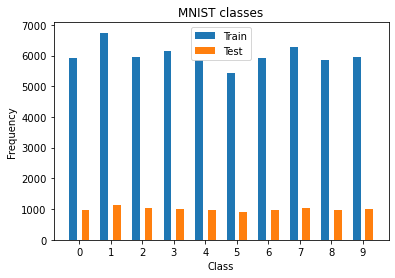

In [4]:
labels = ["%s"%i for i in range(10)]

unique, counts = np.unique(y_train_ori, return_counts=True)
uniquet, countst = np.unique(y_test_ori, return_counts=True)

fig, ax = plt.subplots()
rects1 = ax.bar(unique - 0.2, counts, 0.25, label='Train')
rects2 = ax.bar(unique + 0.2, countst, 0.25, label='Test')
ax.legend()
ax.set_xticks(unique)
ax.set_xticklabels(labels)

plt.title('MNIST classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

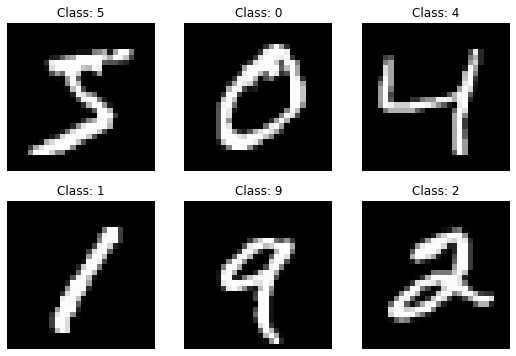

In [5]:
fig, ax = plt.subplots(2, 3, figsize = (9, 6))

for i in range(6):
    ax[i//3, i%3].imshow(X_train_ori[i], cmap='gray')
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title("Class: %d"%y_train_ori[i])
    
plt.show()

In [6]:
# Reduce the image size to its half 
X_train = np.array([image[::2, 1::2] for image in X_train_ori])
X_test  = np.array([image[::2, 1::2] for image in X_test_ori])

y_train = y_train_ori
y_test = y_test_ori

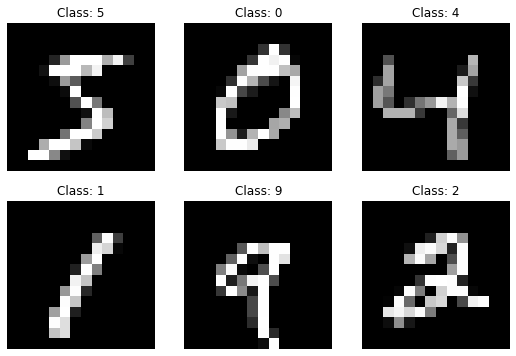

In [7]:
fig, ax = plt.subplots(2, 3, figsize = (9, 6))

for i in range(6):
    ax[i//3, i%3].imshow(X_train[i], cmap='gray')
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title("Class: %d"%y_train_ori[i])
    
plt.show()

In [8]:
X_train = (X_train/255.0).astype('float32').reshape((60000,14*14))
X_test = (X_test/255.0).astype('float32').reshape((10000,14*14))

print(X_train.dtype)
print(X_test.dtype)

print("\nShape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

print("\nMinimum value in X_train:", np.amin(X_train))
print("Maximum value in X_train:", np.amax(X_train))

print("\nMinimum value in X_test:", np.amin(X_test))
print("Maximum value in X_test:", np.amax(X_test))


float32
float32

Shape of X_train:  (60000, 196)
Shape of X_test:  (10000, 196)

Minimum value in X_train: 0.0
Maximum value in X_train: 1.0

Minimum value in X_test: 0.0
Maximum value in X_test: 1.0


1. Dataset preparation

A seguir, o dataset de treinamento do MNIST é particionado na proporção 70/30 e nomeado como Dtrain e Dval respectivamente. Sua estratificação em cada uma das 10 classes também é demonstrada.


Shape of X_Dtrain:  (42000, 196)
Shape of X_Dval:  (18000, 196)


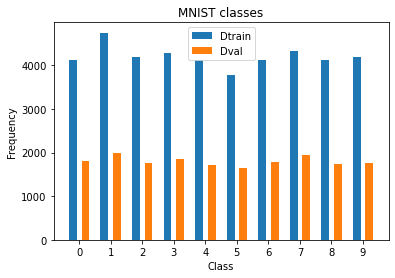

In [9]:
from sklearn.model_selection import train_test_split

seed = 42   # fix seed to make results repeatable
X_Dtrain, X_Dval, y_Dtrain, y_Dval = train_test_split(X_train,
                                                      y_train,
                                                      test_size=0.30,
                                                      random_state=seed)

print("\nShape of X_Dtrain: ", X_Dtrain.shape)
print("Shape of X_Dval: ", X_Dval.shape)

# check for stratification in Dtrain and Dval
unique_t, counts_t = np.unique(y_Dtrain, return_counts=True)
unique_v, counts_v = np.unique(y_Dval, return_counts=True)

fig, ax = plt.subplots()
rects1 = ax.bar(unique_t - 0.2, counts_t, 0.25, label='Dtrain')
rects2 = ax.bar(unique_v + 0.2, counts_v, 0.25, label='Dval')
ax.legend()
ax.set_xticks(unique_t)
ax.set_xticklabels(labels)

plt.title('MNIST classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


2. Training, Evaluating and selecting models

De modo que apenas Dtrain seja utilizado nesta etapa, o projto toma a decisão de uma nova divisão, criando-se Strain e Sval a partir de Dtrain na proporção de 70/30.

In [10]:
# Dtrain split in 70 / 30
X_Strain, X_Sval, y_Strain, y_Sval = train_test_split(X_Dtrain,
                                                      y_Dtrain,
                                                      test_size=0.30,
                                                      random_state=seed)
print("\nShape of X_Strain: ", X_Strain.shape)
print("Shape of X_Sval: ", X_Sval.shape)



Shape of X_Strain:  (29400, 196)
Shape of X_Sval:  (12600, 196)


Em seguida, inicia-se o processo de construção e análise dos três modelos propostos, a saber: Logistic Regression, Neural Network e SVM.

Declaração de bibliotecas:

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from sklearn.model_selection import GridSearchCV
import pandas as pd


Definição de critério de escolha do melhor modelo:

Por decisão de projeto, adota-se o f1-score como parâmetro de otimização e avaliação de modelos conforme as seguintes razões:
* Popularidade
* Conveniencia de ser um medidor de apenas um número, operando dentro do intervalo [0, 1], sendo 1 o melhor caso.
* Por ser uma média harmônica entre Precision e Recall, traz o benefício de maximizar as detecções afirmativas TP e TN (True Positive e True Negative), porém de modo a minimizar de forma balanceada os falsos scores FP e FN (False Positive e False Negative).

Mais detalhes em:

https://en.wikipedia.org/wiki/F-score

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

Desta forma, a função a seguir imprime a avaliação de desempenho de determinado modelo, com base em:
* Matriz de Confusão
* f1-score

In [12]:
def print_report(y_true, y_hat):
    cm = confusion_matrix(y_true, y_hat, labels = unique_t)
    print("\n", cm)
    
    cr = classification_report(y_true, y_hat, labels = unique_t, digits=3)
    print("\n", cr)
    
    f1 = f1_score(y_true, y_hat, labels = unique_t, average = "micro")
    print("f1-score: ", format(f1, ".3f"))
    
    return


Treinamento de Modelos

A seguir, cada um dos três modelos são treinados com Strain em duas etapas (parâmetros default e otimizados por grid de parâmetros), e posteriormente avaliados, conforme critério estabelecido, com Sval.

A adoção desta estratégia se dá pelos seguintes motivos:
* Para se ganhar familiaridade com as diversas funções do Scikit-Learn a serem utilizadas, eliminando-se a complexidade inicial de uso dos hiperparâmetros;
* Para se ter uma base de comparação com os modelos otimizados, estes com uso de hiperparâmetros, de modo que se observe a eficácia da otimização.

Deve-se notar que o resultado da otimização por grid também inclui impressão da combinação de melhores parâmetros encontrados durante o processo.

2.1 Logistic Regression básico

In [13]:
logistic_regression = LogisticRegression(max_iter=400)
logistic_regression.fit(X_Strain, y_Strain)
y_hat_log = logistic_regression.predict(X_Sval)

print_report(y_Sval, y_hat_log)



 [[1203    0    8    3    1    8    9    4    6    3]
 [   1 1408   11    5    1    6    2    5   19    2]
 [   9   10 1072   21   18    8   22   29   29    7]
 [   5   13   45 1101    1   64    7   11   22   16]
 [   0   10    6    0 1070    1   15    4    4   79]
 [  17    9   10   43   14 1000   28    5   31   10]
 [  12    5   15    2   11   12 1185    1    5    1]
 [   6    9   15    5   27    1    0 1153    7   35]
 [  10   35   16   31    6   38   12    4 1090   30]
 [   3   10    3   15   59   10    1   55    6 1088]]

               precision    recall  f1-score   support

           0      0.950     0.966     0.958      1245
           1      0.933     0.964     0.948      1460
           2      0.893     0.875     0.884      1225
           3      0.898     0.857     0.877      1285
           4      0.886     0.900     0.893      1189
           5      0.871     0.857     0.864      1167
           6      0.925     0.949     0.937      1249
           7      0.907     0.91

2.2 Logistic Regression otimizado

In [14]:
parameters = {'C': [1.0, 0.75, 0.5, 0.25]}
logistic_regression = LogisticRegression(max_iter=400)
clf = GridSearchCV(logistic_regression, parameters, scoring='f1_micro')
clf = clf.fit(X_Strain, y_Strain)
y_hat_log = clf.predict(X_Sval)

print_report(y_Sval, y_hat_log)
print('best parameters: ', clf.best_params_)
df_log = pd.DataFrame(clf.cv_results_)   # usar para debug do gridsearch



 [[1203    0    8    3    1    8    9    4    6    3]
 [   1 1408   11    5    1    6    2    5   19    2]
 [   9   10 1072   21   18    8   22   29   29    7]
 [   5   13   45 1101    1   64    7   11   22   16]
 [   0   10    6    0 1070    1   15    4    4   79]
 [  17    9   10   43   14 1000   28    5   31   10]
 [  12    5   15    2   11   12 1185    1    5    1]
 [   6    9   15    5   27    1    0 1153    7   35]
 [  10   35   16   31    6   38   12    4 1090   30]
 [   3   10    3   15   59   10    1   55    6 1088]]

               precision    recall  f1-score   support

           0      0.950     0.966     0.958      1245
           1      0.933     0.964     0.948      1460
           2      0.893     0.875     0.884      1225
           3      0.898     0.857     0.877      1285
           4      0.886     0.900     0.893      1189
           5      0.871     0.857     0.864      1167
           6      0.925     0.949     0.937      1249
           7      0.907     0.91

2.3 Neural Network básica

In [15]:
mlp_classifier = MLPClassifier()
mlp_classifier.fit(X_Strain, y_Strain)
y_hat_mlp = mlp_classifier.predict(X_Sval)

print_report(y_Sval, y_hat_mlp)



 [[1217    1    5    3    0    3    6    2    3    5]
 [   0 1429   13    1    1    1    3    5    7    0]
 [   3    4 1179   11    3    2    2   12    6    3]
 [   2    2   11 1223    1   21    0    3   11   11]
 [   1    3    2    2 1142    4    6    4    3   22]
 [   4    2    1   18    3 1109   16    0    6    8]
 [   5    3    3    1    0    9 1221    1    6    0]
 [   4    5    1    4   11    3    0 1219    1   10]
 [   2   13    5   13    5   13    9    4 1197   11]
 [   2    3    1   12   20    6    0   13    3 1190]]

               precision    recall  f1-score   support

           0      0.981     0.978     0.979      1245
           1      0.975     0.979     0.977      1460
           2      0.966     0.962     0.964      1225
           3      0.950     0.952     0.951      1285
           4      0.963     0.960     0.962      1189
           5      0.947     0.950     0.949      1167
           6      0.967     0.978     0.972      1249
           7      0.965     0.96

2.4 Neural Network otimizada

In [21]:
parameters = {'hidden_layer_sizes': [80, 100, 120],
              'solver': ['lbfgs', 'adam'],
              'learning_rate': ['constant', 'adaptive']}
mlp_classifier = MLPClassifier()
clf = GridSearchCV(mlp_classifier, parameters, scoring='f1_micro')
clf = clf.fit(X_Strain, y_Strain)
y_hat_mlp = clf.predict(X_Sval)

print_report(y_Sval, y_hat_mlp)
print('best parameters: ', clf.best_params_)
df_mlp = pd.DataFrame(clf.cv_results_)   # usar para debug do gridsearch



 [[1220    1    3    2    0    3    4    1    2    9]
 [   1 1433   12    1    1    0    3    7    2    0]
 [   3    3 1190    4    5    3    2    9    3    3]
 [   2    5   15 1225    1   13    2    4    6   12]
 [   0    4    2    0 1147    4    3    4    3   22]
 [   6    1    3   17    2 1122    7    3    4    2]
 [   8    3    2    1    0   10 1220    2    3    0]
 [   1    2    3    7    8    1    0 1225    1   10]
 [   3   12   13   13    5   14    7    1 1194   10]
 [   0    4    1    7   17    6    0   13    5 1197]]

               precision    recall  f1-score   support

           0      0.981     0.980     0.980      1245
           1      0.976     0.982     0.979      1460
           2      0.957     0.971     0.964      1225
           3      0.959     0.953     0.956      1285
           4      0.967     0.965     0.966      1189
           5      0.954     0.961     0.958      1167
           6      0.978     0.977     0.977      1249
           7      0.965     0.97

In [ ]:
df_mlp

PCA para SVM

Como preparação para determinar o número de components (n_components) a ser utilizado de fato durante o Principal Component Análise, executa-se o código a seguir para:
* Verificar o percentual de colaboração de cada componente com a variância total dos dados;
* Definir n_components como o número de componentes que contribui com até 95% do total da variância.

In [17]:
# returns the number of elements where its cumulative variance accounts
# for up to 95% of the total variance
def n_components_pca(v):
    v = -np.sort(-v)
    v = np.cumsum(v)
    v = v <= 0.95
    n = np.sum(v)
    
    return n

# optipmizing pca
pca = PCA(svd_solver='randomized', whiten=True)
pca = pca.fit(X_Strain)
n_pca = n_components_pca(pca.explained_variance_ratio_)
print("n_components definido como: ", n_pca)

# final pca
pca = PCA(n_components = n_pca, svd_solver='randomized', whiten=True)
pca = pca.fit(X_Strain)
X_Strain_pca = pca.transform(X_Strain)
X_Sval_pca = pca.transform(X_Sval)


n_components definido como:  74


2.5 SVM básico

In [18]:
svm_classifier = SVC()
svm_classifier = svm_classifier.fit(X_Strain_pca, y_Strain)
y_hat_svm = svm_classifier.predict(X_Sval_pca)

print_report(y_Sval, y_hat_svm)



 [[1232    1    4    0    0    0    3    2    2    1]
 [   0 1441    7    1    1    2    1    5    2    0]
 [   1    5 1174    5    5    4    4   13   14    0]
 [   1    3   16 1227    1   16    0    7    7    7]
 [   0    4    3    0 1140    1    6    4    3   28]
 [   6    1    3   16    3 1121   11    1    4    1]
 [   7    3    1    1    1    6 1224    0    6    0]
 [   2    3    5    1   13    0    0 1222    3    9]
 [   0   13    6    8    6   13    4    0 1213    9]
 [   1    2    1   16   18    4    0   15    2 1191]]

               precision    recall  f1-score   support

           0      0.986     0.990     0.988      1245
           1      0.976     0.987     0.982      1460
           2      0.962     0.958     0.960      1225
           3      0.962     0.955     0.959      1285
           4      0.960     0.959     0.959      1189
           5      0.961     0.961     0.961      1167
           6      0.977     0.980     0.978      1249
           7      0.963     0.97

2.6 SVM otimizado

In [22]:
parameters = {'C': [1.0, 0.75, 0.5, 0.25],
              'kernel': ['rbf', 'poly', 'sigmoid'],
              'gamma': ['scale', 'auto']}
svm_classifier = SVC()
clf = GridSearchCV(svm_classifier, parameters, scoring='f1_micro')
clf = clf.fit(X_Strain_pca, y_Strain)
y_hat_svm = clf.predict(X_Sval_pca)

print_report(y_Sval, y_hat_svm)
print('best parameters: ', clf.best_params_)
df_svm = pd.DataFrame(clf.cv_results_)   # usar para debug do gridsearch


KeyboardInterrupt: 